# Challenge 1

### Initial datalog code

In [2]:
# (declare-rel inv (Int Int ))
# (declare-var x0 Int)
# (declare-var x1 Int)
# (declare-var y0 Int)
# (declare-var y1 Int)

# (declare-rel fail ())

# (rule (=> (and (= x0 0) (= y0 5000))
#     (inv x0 y0)))

# (rule (=> (and
#         (inv x0 y0)
#         (= x1 (+ x0 1))
#         (= y1 (ite (>= x0 5000) (+ y0 1) y0)))
#     (inv x1 y1)))

# (rule (=> (and (inv x0 y0) (= x0 10000)
#     (not (= y0 x0))) fail))

# (query fail)

### Solve

In [3]:
from z3 import *
from spacer_tutorial import *

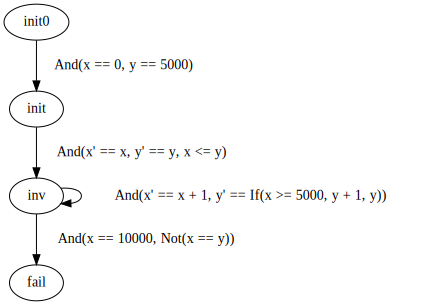

In [4]:
def mk_cfa1():
    A = CFA('prog')
    x, x_out = A.add_var(z3.IntSort(), name='x')
    y, y_out = A.add_var(z3.IntSort(), name='y')
    A.set_entry_node('init0')
    A.set_exit_node('fail')

    N = 5000
    M = N*2
    A.add_edge('init0', 'init', z3.And(x == 0, y == N))
    A.add_edge('init', 'inv', z3.And(x_out == x, y_out == y, x <= y))
    A.add_edge('inv', 'inv', z3.And(x_out == x + 1, y_out == z3.If(x >= N, y + 1, y)))
    A.add_assert('inv', z3.Implies(x == M, x == y))

    return A
cfa1 = mk_cfa1()
cfa1.to_dot()

#### In TR fn I provided additional condition x < y. It makes things work

In [5]:
def mk_challenge_1_orig(N = 0):
    T = Ts('Ts0')
    M = N * 2
    x, x_out = T.add_var(z3.IntSort(), name='x')
    y, y_out = T.add_var(z3.IntSort(), name='y')
    T.Init = And(x == 0, y == N)
    T.Tr = And(x_out == x + 1, y_out == If(x >= N, y + 1, y))
    T.Bad = And(x == M, Not(y == x))
    return T

In [6]:
def mk_challenge_1(N = 5000):
    T = Ts('Ts0')
    x, x_out = T.add_var(z3.IntSort(), name='x')
    y, y_out = T.add_var(z3.IntSort(), name='y')
    z, z_out = T.add_var(z3.IntSort(), name='z')
    n, n_out = T.add_var(z3.IntSort(), name='n')

    T.Init = And(x == 0, y == z, z >= 0, z <= N, n == N)
    T.Tr = And(z_out == z, 
               x_out == x + 1, 
               n_out == n, 
               y_out == If(x >= z, y + 1, y))
    T.Bad = And(x == 2*n, Not(y == x))
    return T

In [7]:
ts_challenge_1 = mk_challenge_1()
HtmlStr(ts_challenge_1)

"Transition System: Ts0<br/>\tInit: And(x == 0, y == z, z >= 0, z <= 5000, n == 5000)<br/>\tBad: And(x == 2*n, Not(y == x))<br/>\tTr: And(z' == z,<br/>    x' == x + 1,<br/>    n' == n,<br/>    y' == If(x >= z, y + 1, y))"

In [8]:
def vc_challenge_1(T):
    Inv = z3.Function('Inv', *(T.sig() + [z3.BoolSort()]))

    InvPre = Inv(*T.pre_vars())
    InvPost = Inv(*T.post_vars())

    all_vars = T.all()
    vc_init = z3.ForAll(all_vars, z3.Implies(T.Init, InvPre))
    vc_ind = z3.ForAll(all_vars, z3.Implies(z3.And(InvPre, T.Tr), InvPost))
    vc_bad = z3.ForAll(all_vars, z3.Implies(z3.And(InvPre, T.Bad), z3.BoolVal(False)))
    return [vc_init, vc_ind, vc_bad], InvPre

vc_chall_1, inv_challenge_1 = vc_challenge_1(ts_challenge_1)
res_challenge_1, answer_challenge_1 = solve_horn(vc_chall_1, max_unfold=40)
res_challenge_1


sat

In [9]:
#SpacerProof(answer_challenge_1)

### Answer

In [10]:
answ_ch_1 = answer_challenge_1.eval(inv_challenge_1)
answ_ch_1

And(Not(z + -2*n >= -4999),
    Not(x + -1*y >= 1),
    Not(y + -1*z <= -1),
    Or(Not(x + -1*y <= -1), Not(y + -1*z >= 1)))

In [11]:
push_not(answ_ch_1)

And(-5000 >= z + -2*n,
    x <= y,
    y >= z,
    Implies(x < y, y <= z))

In [12]:
#def ch_1_program(N):
    # vc_ch_1, inv_ch_1 = vc_challenge_1(mk_challenge_1(N))
    # res_ch_1, answer_ch_1 = solve_horn(vc_ch_1, max_unfold=40)
    # a_ch_1 = answer_ch_1.eval(inv_ch_1)
    # return push_not(a_ch_1)


In [13]:
#ch_1_program(1)

In [14]:
# for x in [*range(20)]:
#   chc = ch_1_program(x)
#   print(f"N = {x}: {chc}")
  
  

In [16]:
fp = Fixedpoint()

a, b, c = Bools('a b c')

fp.register_relation(a.decl(), b.decl(), c.decl())
fp.rule(a,b)
fp.rule(b,c)
fp.set(engine='datalog')

print ("current set of rules\n", fp)
print ("===")
print (fp.query(a))

fp.fact(c)
print ("updated set of rules\n", fp)
print (fp.query(a))
print (fp.get_answer())

current set of rules
 (declare-rel b ())
(declare-rel a ())
(declare-rel c ())
(rule (=> (and b) a))
(rule (=> (and c) b))

===
unsat
updated set of rules
 (declare-rel b ())
(declare-rel a ())
(declare-rel c ())
(rule (=> b a))
(rule (=> c b))
(rule c)

sat
True
